* Check the difference between Coriolis and no Coriolis both under without Hollingsworth conditions (enstrophy conserving = True.)

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [5]:
## load salinity into a dict
paths = ['Oct2014WithoutHollings','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = 'oct2014*_T.nc'
file_patternUs = 'oct2014*_U.nc'
file_patternVs = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternTs))
    pathU = glob(os.path.join(base,pa, file_patternUs))
    pathV = glob(os.path.join(base,pa, file_patternVs))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']
    depT = fT.variables['deptht']

In [7]:
## load grid_T model results
octNoHolling_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014WithoutHollings/oct2014NoHolling_T.nc')
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
octnof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')

In [8]:
octNoHolling_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014WithoutHollings/oct2014NoHolling_U.nc')
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
octnof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')

In [9]:
octNoHolling_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014WithoutHollings/oct2014NoHolling_V.nc')
octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
octnof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')

In [13]:
def quiver_salinity(grid_T1,grid_T2,grid_U1,grid_U2,grid_V1,grid_V2,t1,t2,colormap,st,dep,cmin = -6,cmax = 6,ave = False):
    """Quiver velocity on top of surface salinity"""
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    cm = plt.cm.get_cmap(colormap,12)
    theta = np.pi*29/180
    S = {};U = {};V= {}
    for gridT, gridU,gridV,run, ax in zip([grid_T1,grid_T2],[grid_U1,grid_U2],[grid_V1,grid_V2],['all','nof'],[axs[0],axs[1]]):
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        if ave ==False:
            S[run] =gridT.variables['vosaline'][t1,0]
            S[run] = np.ma.masked_values(S[run],0)
            u = gridU.variables['vozocrtx'][t1,0]
            v = gridV.variables['vomecrty'][t1,0]
            U[run],V[run] = viz_tools.unstagger(u,v)
            #rotate       
            U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
            V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
        else:
            S[run] =np.ma.masked_values(np.nanmean(gridT.variables['vosaline'][t1:t2+1,0],axis = 0),0)
            u = gridU.variables['vozocrtx'][t1:t2+1,0]
            v = gridV.variables['vomecrty'][t1:t2+1,0]
            U[run],V[run] = viz_tools.unstagger(u,v)
            #rotate       
            U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
            V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
            U[run] = np.nanmean(U[run],axis = 0)
            V[run] = np.nanmean(V[run],axis = 0)
            
        mesh=ax.pcolormesh(lon,lat,S[run],vmin =0,vmax = 33,cmap=cm) 
        cbar = fig.colorbar(mesh,ax = ax)
        cbar.set_label('Practical Salinity')
        quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U[run][::st, ::st], V[run][::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ## add minimum salinity plot if available
    sal_diff = S['nof'] - S['all']
    U_diff = U['nof'] - U['all']
    V_diff = V['nof'] - V['all']
    ax = axs[2]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    cbar = fig.colorbar(mesh,ax = ax)
    cbar.set_label('Difference of Practical Salinity')
    quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=12,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])

# Check spatial pattern at instantaneous time

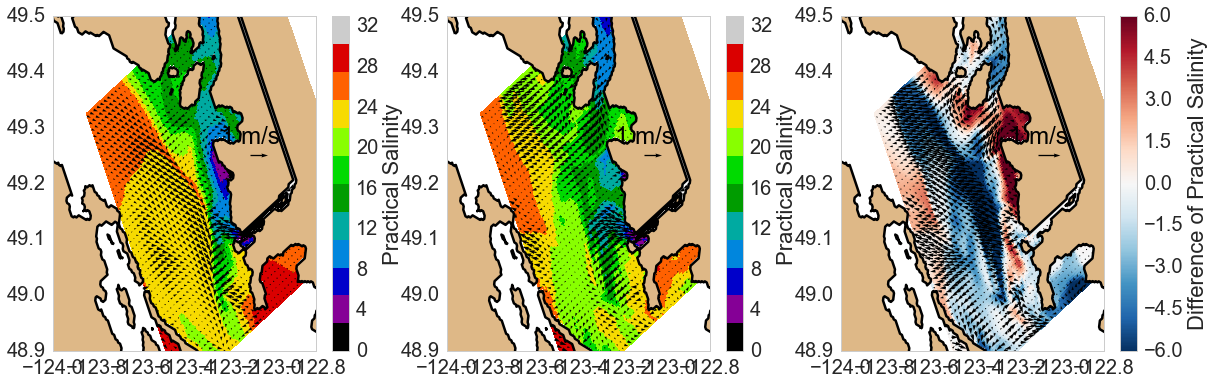

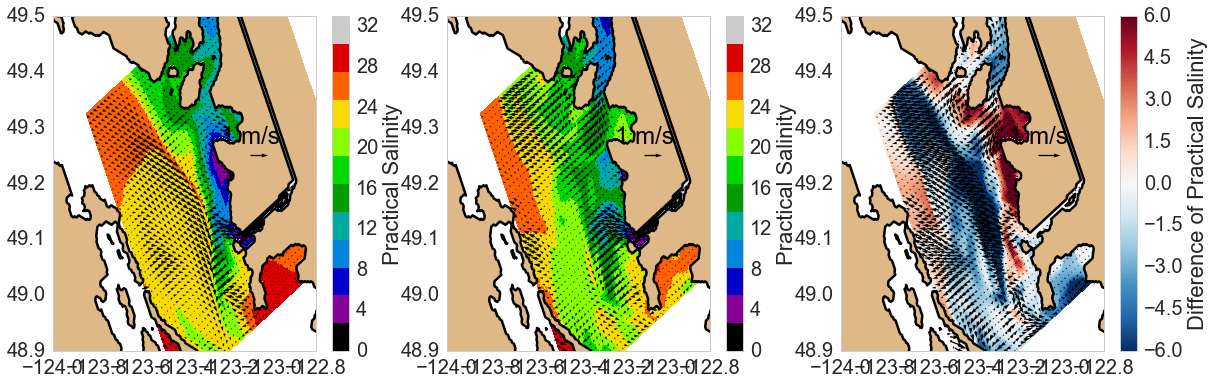

In [14]:
quiver_salinity(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,50,50,'spectral',3,0,ave = False)
quiver_salinity(octNoHolling_T,octnof_T,octNoHolling_U,octnof_U,octNoHolling_V,octnof_V,50,50,'spectral',3,0,ave = False)

* near final time step

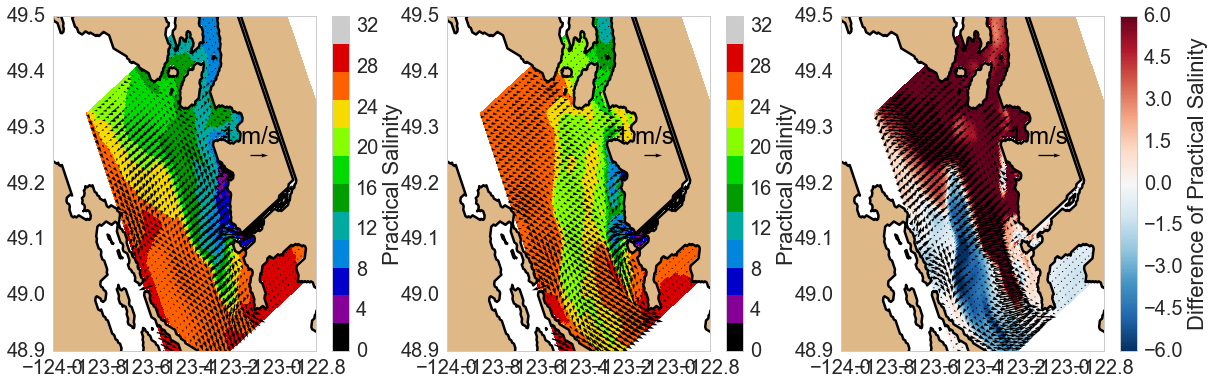

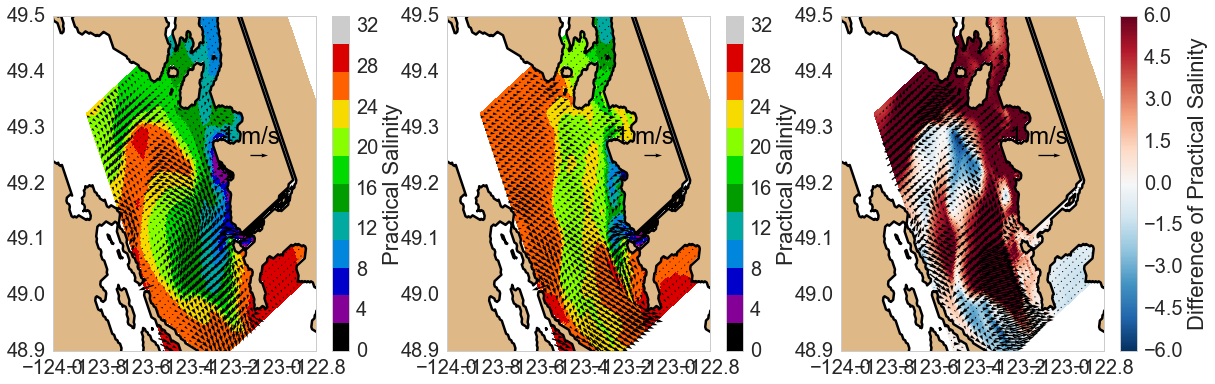

In [15]:
quiver_salinity(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,743,743,'spectral',3,0,ave = False)
quiver_salinity(octNoHolling_T,octnof_T,octNoHolling_U,octnof_U,octNoHolling_V,octnof_V,743,743,'spectral',3,0,ave = False)

# Check a single place in a time series

In [25]:
def station_time_series(ax,gridT1,gridT2,gridT3,t1,t2,dep,j,i,string ='Salinity'):
    """
    """
  
    Vars = {};
    time = np.arange(t1,t2+1)
    for gridT,run in zip([gridT1,gridT2,gridT3],['all','allNoHolling','nof']):

        if string == 'Salinity':
            Vars[run] =gridT.variables['vosaline'][t1:t2+1,dep,j,i]
            ax.set_ylabel('Salinity')
        elif string =='U':
            Vars[run] =gridT.variables['vozocrtx'][t1:t2+1,dep,j,i]
            ax.set_ylabel('U')
        elif string =='V':
            Vars[run] =gridT.variables['vomecrty'][t1:t2+1,dep,j,i]
            ax.set_ylabel('V')
        Vars[run] = np.ma.masked_values(Vars[run],0)
        ax.plot(time,Vars[run],label =run)
        ax.set_xlabel('Time index')
        ax.legend(loc = 'best')   

* Sandheads

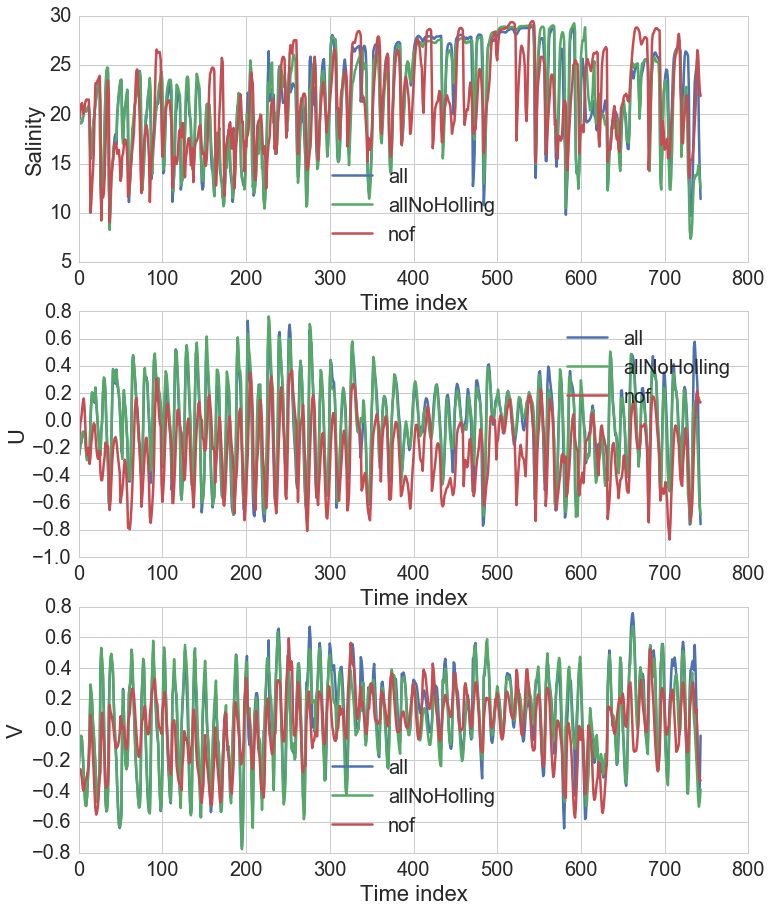

In [48]:
fig,axs = plt.subplots(3,1,figsize = (12,15))
station_time_series(axs[0],octall_T,octNoHolling_T,octnof_T,0,743,0,48,53,string = 'Salinity')
station_time_series(axs[1],octall_U,octNoHolling_U,octnof_U,0,743,0,48,53,string = 'U')
station_time_series(axs[2],octall_V,octNoHolling_V,octnof_V,0,743,0,48,53,string = 'V')

* Point Atkinson

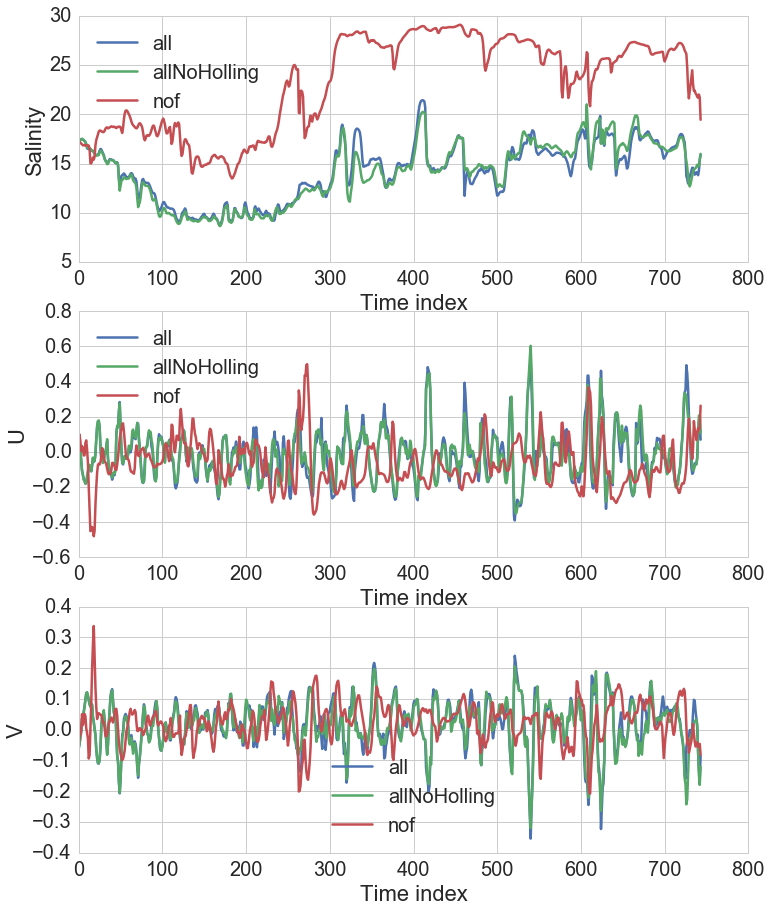

In [49]:
fig,axs = plt.subplots(3,1,figsize = (12,15))
station_time_series(axs[0],octall_T,octNoHolling_T,octnof_T,0,743,0,86,89,string = 'Salinity')
station_time_series(axs[1],octall_U,octNoHolling_U,octnof_U,0,743,0,86,89,string = 'U')
station_time_series(axs[2],octall_V,octNoHolling_V,octnof_V,0,743,0,86,89,string = 'V')

* Northwest point

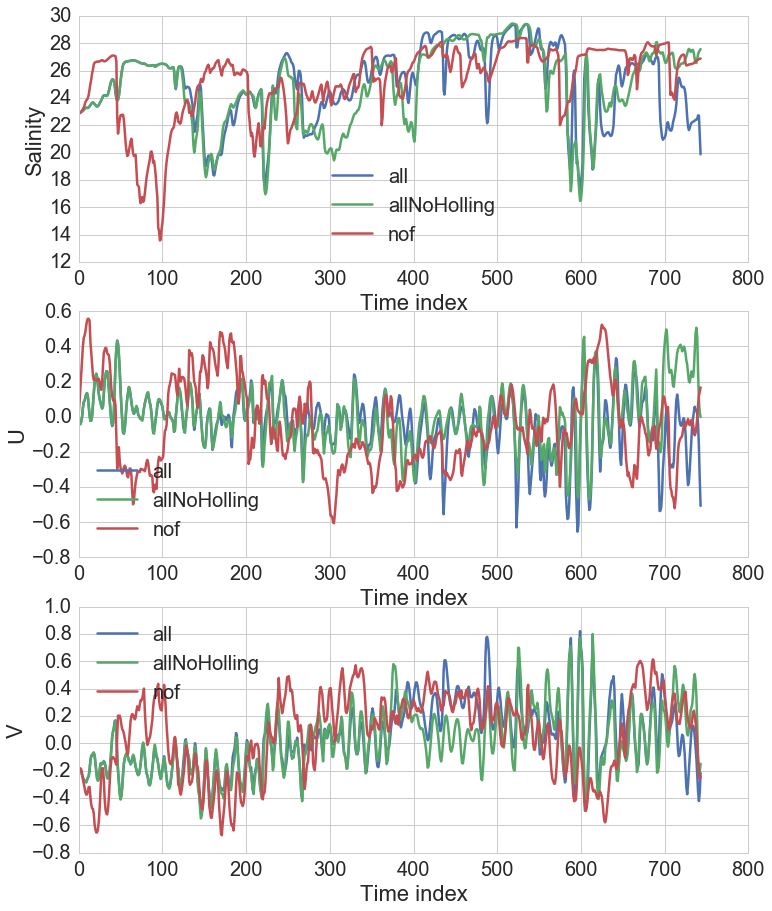

In [45]:
fig,axs = plt.subplots(3,1,figsize = (12,15))
station_time_series(axs[0],octall_T,octNoHolling_T,octnof_T,0,743,0,97,27,string = 'Salinity')
station_time_series(axs[1],octall_U,octNoHolling_U,octnof_U,0,743,0,97,27,string = 'U')
station_time_series(axs[2],octall_V,octNoHolling_V,octnof_V,0,743,0,97,27,string = 'V')

* This suggests me that: 

 Spatially, Hollingsworth affects northwest part of my subdomain more than at the river mouth in the surface currents.
 
 Temporally, this strong signal of influence occurs after time index 400, so, after half of the simulation.